In [ ]:
# Author: Matthew McFee
# DAT112 - Assignment #2
# July 23, 2020

# Install wget with pip and download the data files

# These should be commented in the actual .py as these are Jupyter Notebook
# specific 
#!pip install wget

#!wget "https://support.scinet.utoronto.ca/~ejspence/50x50flowers.images.train.npy"
#!wget "https://support.scinet.utoronto.ca/~ejspence/50x50flowers.targets.train.npy"
#!wget "https://support.scinet.utoronto.ca/~ejspence/50x50flowers.images.test.npy"
#!wget "https://support.scinet.utoronto.ca/~ejspence/50x50flowers.targets.test.npy"

In [ ]:
# Load the data files
import numpy as np

def load_data(image_path, targets_path):

  #print("Reading flowers input file.")
  images = np.load(image_path)

  #print("Reading flowers target file.")
  targets = np.load(targets_path)

  return images, targets

# Hardcoded file paths because the assignment guidelines said this is okay
TRAIN_IMAGE_PATH = "50x50flowers.images.train.npy"
TRAIN_TARGETS_PATH = "50x50flowers.targets.train.npy"
TEST_IMAGE_PATH = "50x50flowers.images.test.npy"
TEST_TARGETS_PATH = "50x50flowers.targets.test.npy"

print("Reading flowers input file.")
print("Reading flowers target file.")

training_images, training_targets = load_data(TRAIN_IMAGE_PATH, 
                                              TRAIN_TARGETS_PATH)

test_images, test_targets = load_data(TEST_IMAGE_PATH, TEST_TARGETS_PATH)

Reading flowers input file.
Reading flowers target file.


In [ ]:
# Preprocess data 
from keras.utils import to_categorical

# Odd issue where to_categorical adds an additional 18th class, solution is to 
# subtract 1 from all labels, so class labels start from 0

training_targets = training_targets - 1
test_targets = test_targets - 1

y_train = to_categorical(training_targets, num_classes=17)
y_test = to_categorical(test_targets, num_classes=17)

Using TensorFlow backend.


In [ ]:
# Function that builds a model 

# The model will be a simple convolutional neural network

# Import the necessary Keras libaries
# from keras.models import Sequential
# from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow import keras
from tensorflow.keras import layers

# This is a simple model for part 1 to show that we have overfitting problems
def build_simple_model():
  
  print("Building network.")

  # Using a sequential model
  model = Sequential()
  
  # First convolutional layer, with input shape (50, 50, 3)
  model.add(Conv2D(32, kernel_size=3, activation="relu", input_shape=(50,50,3)))

  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(32, kernel_size=3, activation="relu"))

  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

  model.add(Conv2D(64, kernel_size=1, activation="relu"))

  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  
  # Flatten the data for final categorization
  model.add(Flatten())

  # Final classification layer, using softmax, with 17 nodes since there are 
  # 17 classes 
  model.add(Dense(17, activation="softmax"))

  return model

# This is my complex model for part 2
# Updating to use Keras functional API, and to include "unfrozen" dropout layers
def build_complex_model():
  
  print("Building network.")

  # Using a sequential model
  input = keras.Input(shape=(50, 50, 3), name="img")
  #x = layers.Dropout(0.5)(input, training = True)
  
  # First convolutional layer, with input shape (50, 50, 3)
  x = layers.Conv2D(32, 3, activation="relu")(input)
  x = layers.Dropout(0.5)(x, training = True)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)
  #x = layers.Dropout(0.5)(x, training = True)
  
  # Additional convolutional layers. I played around with the number and number
  # of filters per convolution layer. I've seen a trend of using 32 and then 64, 
  # and then 128 etc. 

  #x = layers.Conv2D(64, 3, activation="relu")(x)
  #x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
  
  x = layers.Conv2D(64, 3, activation="relu")(x)
  x = layers.Dropout(0.5)(x, training = True)
  x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

  x = layers.Conv2D(64, 3, activation="relu")(x)
  x = layers.Dropout(0.5)(x, training = True)
  x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

  # Flatten the data for input into a densely connect network
  x = layers.Flatten()(x)

  # Used fully connected dense layers with dropout regularization. I played 
  # around with the dropout and found 0.5 seems to regulate overfitting better
  # than other values. Strong regularization was needed as the model was 
  # overfitting badly without it.

  #x = layers.Dropout(0.5)(x, training = True)
  #x = layers.Dense(64, activation="relu")(x)

  x = layers.Dropout(0.5)(x, training = True)
  x = layers.Dense(64, activation="relu")(x)
  
  #x = layers.Dropout(0.5)(x, training = True)
  x = layers.Dropout(0.5)(x, training = True)

  # Final classification layer, using softmax, with 17 nodes since there are 
  # 17 classes 
  output = layers.Dense(17, activation = "softmax")(x)

  model = keras.Model(input, output, name = "BNN")

  return model

model = build_complex_model()

model.summary()

Building network.
Model: "BNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 50, 50, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 48, 48, 32)        896       
_________________________________________________________________
dropout (Dropout)            (None, 48, 48, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 22, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 6

In [ ]:
# These function will actually train the model on the training set, and then run
# the test data set through the trained model, and report the metrics specified 
# in the asssignment criteria

def compile_model(model, optimizer_func, loss_func, metrics):

  # Compile the model using the select optimizer function, loss function,
  # and appropriate metrics 

  model.compile(optimizer=optimizer_func, loss=loss_func, 
                metrics=metrics)
  return model

In [ ]:
# It is clear that we are overfitting on the training set with even 
# a simple one layer convolutional network

# The purpose of this code will be to generate new training data by
# modifying existing data points in meaningful ways. Luckily, this 
# is already easy to do using Keras.

# Trying the stock Keras docs example configuration with added rescaling

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    # Important to rescale data for neural networks
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

valgen = ImageDataGenerator(
    rescale=1./255)

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(training_images, y_train)

# Use the fit method on the existing training data

# Train the data generator classes on the available images
#datagen.fit(X_train)
#valgen.fit(X_val)

# Adapt the old train and test function for use with data generators
def train_test_model(model, datagen, valgen, X_train, y_train, X_val, y_val, 
                     epochs, batch_size):

  print("Training network.")
  
  # We store the return values of model.fit in the history variable, for easy
  # plotting of loss  function during model training
  #history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size), 
  #                    steps_per_epoch=len(X_train)/32, 
  #                    validation_data=(X_test, y_test), 
  #                    epochs=epochs)

  #history = model.fit_generator(datagen.flow(X_train, y_train), 
                                #steps_per_epoch=313,
                                #validation_data=(X_test, y_test),
                                #epochs=epochs)

  history = model.fit_generator(datagen.flow(X_train, y_train), 
                                validation_data=valgen.flow(X_val, y_val, batch_size),
                                epochs=epochs, verbose=1, 
                                steps_per_epoch = X_train.shape[0]//batch_size)

  return history 

In [ ]:
# Build, compile, train, and test the model

# model = build_complex_model()

# These can be adjusted as needed 
# Commonly used
OPTIMIZER = "adam"
# This is a multiclass problem so this is appropriate
LOSS_FUNC = "categorical_crossentropy"
METRICS = ["accuracy"]
# After 30 epochs training loss stops changing
EPOCHS = 100
BATCH_SIZE = 40

model = compile_model(model, OPTIMIZER, LOSS_FUNC, METRICS)

#X_train = training_images
#X_test = test_images

history = train_test_model(model, datagen, valgen, X_train, y_train,
                           X_val, y_val, EPOCHS, BATCH_SIZE)

#history = train_and_test_model(model, X_train, X_test, y_train, y_test, EPOCHS,
                               #BATCH_SIZE)

print("The training score is ", [history.history["loss"][-1], 
      history.history["accuracy"][-1]])

# Loss is very high even though accuracy isn't great. Likely a few very incorrect
# data points blowing up the error?

results = model.evaluate(test_images, y_test)

print("The test score is ", results)


Training network.
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
20/20 [==============================] - 1s 53ms/step - loss: 2.9307 - accuracy: 0.0516 - val_loss: 2.8476 - val_accuracy: 0.0441
Epoch 2/100
20/20 [==============================] - 1s 42ms/step - loss: 2.8056 - accuracy: 0.0737 - val_loss: 2.7490 - val_accuracy: 0.1176
Epoch 3/100
20/20 [==============================] - 1s 38ms/step - loss: 2.7246 - accuracy: 0.1058 - val_loss: 2.6368 - val_accuracy: 0.1176
Epoch 4/100
20/20 [==============================] - 1s 39ms/step - loss: 2.6297 - accuracy: 0.1047 - val_loss: 2.6543 - val_accuracy: 0.1066
Epoch 5/100
20/20 [==============================] - 1s 39ms/step - loss: 2.5615 - accuracy: 0.1234 - val_loss: 2.5612 - val_accuracy: 0.1250
Epoch 6/100
20/20 [==============================] - 1s 40ms/step - loss: 2.5201 - accuracy: 0.1688 - val_loss: 2.4599 - val_accuracy: 0.1471
Epoch 7/100
20/20 [==============================] - 1

In [ ]:
#import matplotlib.pyplot as plt

#plt.title("Loss vs. Epoch (Model Training)")
#plt.ylabel("Loss")
#plt.xlabel("Epoch")
#plt.plot(history.history["loss"])
#plt.show()

In [ ]:
def generate_graph(sample, model, num_iter):

  predictions = []

  for i in range (1, num_iter + 1):

    #sample = np.expand_dims(sample, axis=0)
    predictions.append(model.predict(sample))

  return predictions

In [ ]:
import matplotlib.pyplot as plt 
import pandas as pd

sample = test_images[66,:,:,:]
sample = np.expand_dims(sample, axis = 0)

predictions = generate_graph(sample, model, 100)
classes = list(range(1, 18))
print(predictions)

predictions = np.asarray(predictions).reshape(100, 17)

predictions = pd.DataFrame(predictions)

predictions.head()

[array([[1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.1352842e-25,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00]], dtype=float32), array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]], dtype=float32), array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]], dtype=float32), array([[1.8913415e-24, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00,
        0.0000000e+00]], dtype=float32), array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]], dtype=float32), array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,1.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.135284e-25,0.0,0.0,0.0,0.0,0.0
1,1.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0
2,1.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0
3,1.891342e-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,1.0,0.0,0.0
4,0.000000e+00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0


Generating output plot for test case 66


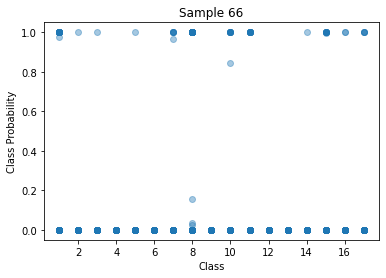

In [ ]:
# No matter which sample I select I get very little spread. The paper in the 
# assignment description was not for CNN, so I just applied the dropout concept
# from the following paper on CNNs

# "Bayesian CNN is therefore as simple as using dropout after every convolution 
# layer beforepooling.""

print("Generating output plot for test case 66")
plt.scatter(x=classes*predictions.shape[0], y=predictions.iloc[:,:].values, alpha=0.4)
plt.xlabel("Class")
plt.ylabel("Class Probability")
plt.title("Sample 66")
plt.show()

In [ ]:
print(predictions)

              0    1    2    3    4   ...   12   13            14   15   16
0   3.021251e-15  0.0  0.0  0.0  0.0  ...  0.0  0.0  1.000000e+00  0.0  0.0
1   0.000000e+00  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.000000e+00  0.0  0.0
2   0.000000e+00  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.000000e+00  0.0  1.0
3   0.000000e+00  0.0  0.0  0.0  0.0  ...  0.0  1.0  0.000000e+00  0.0  0.0
4   1.442687e-04  0.0  0.0  0.0  0.0  ...  0.0  0.0  9.998558e-01  0.0  0.0
..           ...  ...  ...  ...  ...  ...  ...  ...           ...  ...  ...
95  0.000000e+00  0.0  0.0  0.0  0.0  ...  0.0  0.0  1.000000e+00  0.0  0.0
96  0.000000e+00  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.000000e+00  0.0  0.0
97  0.000000e+00  0.0  0.0  0.0  0.0  ...  0.0  0.0  5.124011e-08  0.0  0.0
98  0.000000e+00  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.000000e+00  0.0  0.0
99  0.000000e+00  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.000000e+00  0.0  0.0

[100 rows x 17 columns]
